# Train script for CNN VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
import torch

import sys
sys.path.append("../../Modules")
sys.path.append("../../Datasets")

# local imports
from train import train
from helpers import kl_loss,nll_loss,mse_loss,kl_loss_multi
from models import CNNVAESmall
from ToyDatasets.timeSeries import Sinusoids

## Define dataset loader

In [2]:
batch_size = 32
num_steps = 16
dataset_size = 5000
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)

## Define model

In [3]:
model = CNNVAESmall(input_size=1,conv_size=160,latent_size=64,output_size=num_classes,use_softmax=True)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()
    x = Variable(initial_batch).type(torch.FloatTensor).transpose(1,0)
    test,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == num_classes)
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 860778
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,verbose=True,cooldown=5)

## Run trainer


Train (1 2%) elbo: -2.1801 r_loss: -2.1801 kl: 19.1251 aux_loss: 0.0000 beta 0.00e+00
Valid (1 2%) elbo: -2.0258 r_loss: -2.0258 kl: 66.1176 aux_loss: 0.0000 beta 0.00e+00

Train (2 4%) elbo: -1.8122 r_loss: -1.8047 kl: 36.7477 aux_loss: 0.0000 beta 2.04e-04
Valid (2 4%) elbo: -1.5533 r_loss: -1.5368 kl: 80.7465 aux_loss: 0.0000 beta 2.04e-04

Train (3 6%) elbo: -1.3512 r_loss: -1.3237 kl: 67.3784 aux_loss: 0.0000 beta 4.08e-04
Valid (3 6%) elbo: -1.3235 r_loss: -1.2904 kl: 81.2450 aux_loss: 0.0000 beta 4.08e-04

Train (4 8%) elbo: -1.2319 r_loss: -1.1877 kl: 72.1298 aux_loss: 0.0000 beta 6.12e-04
Valid (4 8%) elbo: -1.2240 r_loss: -1.1851 kl: 63.4491 aux_loss: 0.0000 beta 6.12e-04

Train (5 10%) elbo: -1.1987 r_loss: -1.1414 kl: 70.1691 aux_loss: 0.0000 beta 8.16e-04
Valid (5 10%) elbo: -1.0910 r_loss: -1.0341 kl: 69.7053 aux_loss: 0.0000 beta 8.16e-04

Train (6 12%) elbo: -1.1835 r_loss: -1.1182 kl: 64.0078 aux_loss: 0.0000 beta 1.02e-03
Valid (6 12%) elbo: -1.2064 r_loss: -1.1493 k


Train (48 96%) elbo: -0.9055 r_loss: -0.6047 kl: 31.3629 aux_loss: 0.0000 beta 9.59e-03
Valid (48 96%) elbo: -0.9452 r_loss: -0.6473 kl: 31.0601 aux_loss: 0.0000 beta 9.59e-03

Train (49 98%) elbo: -0.9326 r_loss: -0.6261 kl: 31.2893 aux_loss: 0.0000 beta 9.80e-03
Valid (49 98%) elbo: -0.8723 r_loss: -0.5569 kl: 32.1984 aux_loss: 0.0000 beta 9.80e-03

Train (50 100%) elbo: -0.9300 r_loss: -0.6218 kl: 30.8118 aux_loss: 0.0000 beta 1.00e-02
Valid (50 100%) elbo: -0.8609 r_loss: -0.5629 kl: 29.8043 aux_loss: 0.0000 beta 1.00e-02


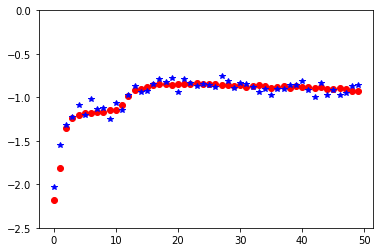

In [5]:
# use at least 50 iterations to get good results
train(data_loader,valid_data_loader,model,optimizer,scheduler,loss_fn=nll_loss,kl_loss_fn=kl_loss,n_iters=50,use_softmax=True,max_beta=1e-2,print_every=1,plot_pred=False)

In [6]:
#torch.save(model.state_dict(),"Saved_models/CNNVAE_nll.pt")